In [1]:
import pandas as pd
import geopandas as gpd
import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Load Data

In [2]:
trips = pd.read_excel("data/EXCEL/UNLINKED_Public.xlsx")
taz = gpd.read_file("data/BPM_TAZ2010.shp")

In [3]:
pd.options.display.max_columns = None

In [4]:
COUNTIES_TAZ = {1: "Manhattan",
                2: "Queens",
                3: "Bronx",
                4: "Brooklyn",
                5: "Staten Island"}
nyc_taz = taz[taz['REGION'] == 1].reset_index(drop=True)
nyc_taz["COUNTY"] = nyc_taz["COUNTYCODE"].apply(lambda x: COUNTIES_TAZ[x])
nyc_taz.head()

,ID,AREA,AREA1,TAZ_ID1,BPZ3_ID,REGION,COUNTYCODE,geometry,COUNTY
0,1009,0.196601,0.196601,1009,3257,1,3,"POLYGON ((-73.8236 40.89089999999999, -73.8235...",Bronx
1,903,0.551513,0.551513,903,3151,1,3,"POLYGON ((-73.921145 40.887094, -73.9207009999...",Bronx
2,901,0.100066,0.100066,901,3149,1,3,"POLYGON ((-73.9041 40.9083, -73.9036 40.9099, ...",Bronx
3,902,0.194815,0.194815,902,3150,1,3,POLYGON ((-73.90649999999999 40.90159999999999...,Bronx
4,900,0.169347,0.169347,900,3148,1,3,"POLYGON ((-73.9084 40.8993, -73.90729999999999...",Bronx


In [5]:
trips["OTAZ"]
trips_with_origin = trips.merge(nyc_taz, left_on="OTAZ", right_on="TAZ_ID1")
trips_with_od = trips_with_origin.merge(nyc_taz, left_on="DTAZ", right_on="TAZ_ID1", suffixes=("_O", "_D"))

In [7]:
to_manhattan = trips_with_od["COUNTY_D"] == "Manhattan"
from_manhattan = trips_with_od["COUNTY_O"] == "Manhattan"
manhattan_only = trips_with_od[to_manhattan | from_manhattan]
manhattan_gdf = gpd.GeoDataFrame(manhattan_only.reset_index(drop=True))
manhattan_gdf["geometry"] = manhattan_gdf["geometry_D"]

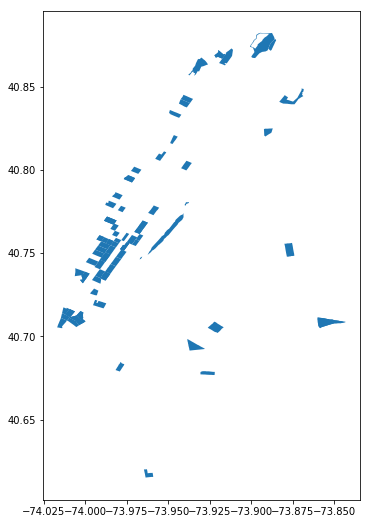

In [17]:
night_only = manhattan_gdf[manhattan_gdf["TRP_DEP_HR"] < 6]

# from travel survey docs
SUBWAY_MODE = 15
subway_night_trips = night_only[night_only["ULTMODE"] == SUBWAY_MODE]
subway_night_trips.plot(figsize=(16, 9))

## Find likely subway path

In [43]:
!wget -nc -O data/routes.zip http://faculty.baruch.cuny.edu/geoportal/data/nyc_transit/jan2017/routes_nyc_subway_jan2017.zip
!cd data; unzip -o routes.zip

!wget -nc -O data/stops.zip http://faculty.baruch.cuny.edu/geoportal/data/nyc_transit/jan2017/stops_nyc_subway_jan2017.zip
!cd data; unzip -o stops.zip

File `data/routes.zip' already there; not retrieving.
Archive:  routes.zip
  inflating: routes_nyc_subway_jan2017.shp  
  inflating: routes_nyc_subway_jan2017.shx  
  inflating: routes_nyc_subway_jan2017_iso.xml  
  inflating: routes_nyc_subway_jan2017.dbf  
  inflating: routes_nyc_subway_jan2017.pdf  
  inflating: routes_nyc_subway_jan2017.prj  
rm: cannot remove 'stops.zip': No such file or directory
--2018-01-23 15:51:48--  http://faculty.baruch.cuny.edu/geoportal/data/nyc_transit/jan2017/stops_nyc_subway_jan2017.zip
Resolving faculty.baruch.cuny.edu (faculty.baruch.cuny.edu)... 150.210.226.155
Connecting to faculty.baruch.cuny.edu (faculty.baruch.cuny.edu)|150.210.226.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125971 (123K) [application/x-zip-compressed]
Saving to: ‘data/stops.zip’

data/stops.zip      100%[===================>] 123.02K   806KB/s    in 0.2s    

2018-01-23 15:51:58 (806 KB/s) - ‘data/stops.zip’ saved [125971/125971]

Archive:  stop

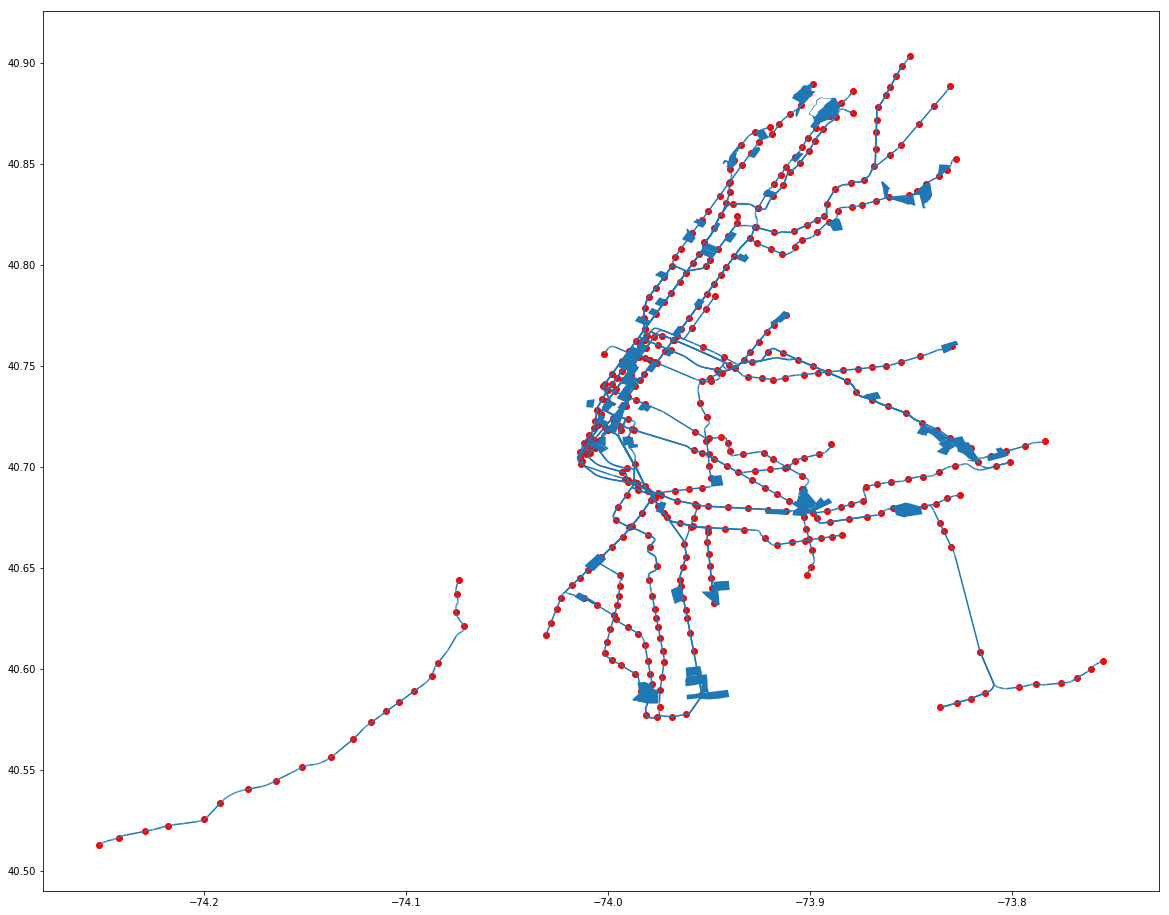

In [101]:
#TODO: construct graph
routes = gpd.read_file("data/routes_nyc_subway_jan2017.shp")
stops = gpd.read_file("data/stops_nyc_subway_jan2017.shp")
routes = routes.to_crs(epsg="4326")
stops = stops.to_crs(epsg="4326")
#routes.plot(figsize=(16, 9))
ax = stops.plot(c='red', figsize=(20, 20))
routes.plot(ax=ax)
subway_night_trips.plot(ax=ax)
stops["base_geom"] = stops["geometry"]

## TODO


1. Expand buffer zone to make sure every origin TAZ has a list of candidate stops

In [134]:
subway_night_trips["geometry"] = subway_night_trips["geometry_O"]
stops["geometry"] = stops["base_geom"]
stops["buffered"] = stops.buffer(.002)
stops["geometry"] = stops["buffered"]
joined_o = gpd.sjoin(subway_night_trips, stops, op='intersects', how='left')
#ax = stops.plot(figsize=(16, 16))
no_candidate = joined_o["stop_lat"].isnull()
interesting = joined_o[no_candidate]

to_join = interesting[subway_night_trips.columns]
stops['geometry'] = stops['base_geom']
stops['buffered'] = stops.buffer(.003)
stops['geometry'] = stops['buffered']
expanded_buffer = gpd.sjoin(to_join, stops, op='intersects', how='left')
joined_o.loc[no_candidate] = expanded_buffer
assert len(joined_o[joined_o["stop_lat"].isnull()]) == 0
del joined_o["index_right"]

/home/christian/.miniconda2/envs/datacourse/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


2. Repeat the code below to get destination candidates

In [187]:
joined_o["geometry"] = joined["geometry_D"]
stops["geometry"] = stops["base_geom"]
stops["buffered"] = stops.buffer(.002)
stops["geometry"] = stops["buffered"]
joined_d = gpd.sjoin(joined_o, stops, op='intersects', how='left', lsuffix="O", rsuffix="D")
#ax = stops.plot(figsize=(16, 16))
no_candidate = joined_d["stop_lat_D"].isnull()
interesting = joined_d[no_candidate]

to_join = interesting
del to_join["index_D"]
for c in stops.columns:
    del to_join[c + "_D"]
stops['geometry'] = stops['base_geom']
stops['buffered'] = stops.buffer(.0115)
stops['geometry'] = stops['buffered']
expanded_buffer = gpd.sjoin(to_join, stops, op='intersects', how='left', lsuffix="O", rsuffix="D")
stops_cols = set(stops.columns)
expanded_buffer.columns = [(c if c not in stops_cols else c + "_D") for c in expanded_buffer.columns]
joined_d.loc[no_candidate] = expanded_buffer
assert len(joined_d[joined_d["stop_lat_D"].isnull()]) == 0

3. Develop the graph of the subway, where weights are distances between stops?

In [ ]:
stops["geometry"] = stops["base_geom"]

stops["trains_list"] = stops["trains"].str.split(" ")
stops_with_id = stops.set_index("stop_id")
stops_cats = pd.get_dummies(stops_with_id["trains_list"].apply(pd.Series).stack()).sum(level=0)
full_stops = stops_with_id.join(stops_cats)
for line in stops_cats.columns:
    line_rows = full_stops[full_stops[line] == 1]
    break

,stop_id,stop_name,stop_lat,stop_lon,stop_id2,trains,GEOID,NAMELSAD,geometry,base_geom,buffered,trains_list
index_D,,,,,,,,,,,,
91,127,Times Sq - 42 St,40.755290,-73.987495,,1 2 3,36061,New York County,POINT (-73.98749499999998 40.7552900000332),POINT (-73.98749499999998 40.7552900000332),"POLYGON ((-73.97599499999998 40.7552900000332,...","[1, 2, 3]"
139,725,Times Sq - 42 St,40.755477,-73.987691,,7,36061,New York County,POINT (-73.98769099999998 40.7554770000332),POINT (-73.98769099999998 40.7554770000332),"POLYGON ((-73.97619099999999 40.7554770000332,...",[7]
142,902,Times Sq - 42 St,40.755983,-73.986229,,S,36061,New York County,POINT (-73.98622900000001 40.7559830000332),POINT (-73.98622900000001 40.7559830000332),"POLYGON ((-73.97472900000001 40.7559830000332,...",[S]
209,R16,Times Sq - 42 St,40.754672,-73.986754,,N Q R W,36061,New York County,POINT (-73.98675399999999 40.75467200003319),POINT (-73.98675399999999 40.75467200003319),POLYGON ((-73.97525399999999 40.75467200003319...,"[N, Q, R, W]"


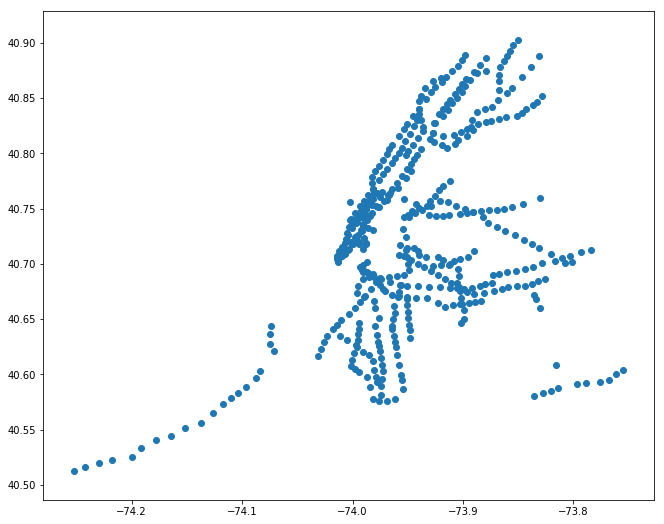

In [224]:
ax = stops.plot(figsize=(16, 9))
stops[stops["stop_name"].str.contains("Times")]

In [247]:
times = pd.read_csv("data/mta_gtfs/stop_times.txt")
stops = pd.read_csv("data/mta_gtfs/stops.txt")
transfers = pd.read_csv("data/mta_gtfs/transfers.txt")

,stop_name,stop_lat,stop_lon,stop_id2,trains,GEOID,NAMELSAD,geometry,base_geom,buffered,trains_list,1,2,3,4,5,6,7,A,B,C,D,E,F,G,J,L,M,N,Q,R,S,SIR,W,Z
stop_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
101,Van Cortlandt Park - 242 St,40.889248,-73.898583,,1,36005,Bronx County,POINT (-73.89858299999996 40.88924800003321),POINT (-73.89858299999996 40.88924800003321),POLYGON ((-73.88708299999996 40.88924800003321...,[1],1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [258]:
stops[stops.stop_name.str.contains("Times")]
transfers[transfers["from_stop_id"].str.contains("127") | transfers["to_stop_id"].str.contains("127")]


616

In [270]:
times.head(1)

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,drop_off_type,shape_dist_traveled
0,A20171105SAT_036000_GS.N01R,06:00:00,06:00:00,901N,1,NaN,0,0,NaN


In [352]:
all_trips = set()
def stateful_filter(g):
    global all_trips
    prev_len = len(all_trips)
    all_trips = all_trips.union(set(g.stop_id))
    new_len = len(all_trips)
    if new_len > prev_len:
        return True
    return False
    
q = times.groupby("trip_id").filter(stateful_filter)
m = q.merge(stops, on="stop_id")
grouped = m.groupby("trip_id")

In [298]:
s.add("h")
s

{'g', 'h'}

In [335]:
test_1 = stops.set_index("stop_id").loc["G26"]
test_2 = stops.set_index("stop_id").loc["G28"]
ll_1 = (test_1.stop_lon, test_1.stop_lat)
ll_2 = (test_2.stop_lon, test_2.stop_lat)
l1 = shapely.geometry.Point(ll_1)
l2 = shapely.geometry.Point(ll_2)
l1.distance(l2)
test_1, test_2

(stop_code                   NaN
 stop_name         Greenpoint Av
 stop_desc                   NaN
 stop_lat                40.7314
 stop_lon               -73.9544
 zone_id                     NaN
 stop_url                    NaN
 location_type                 1
 parent_station              NaN
 Name: G26, dtype: object, stop_code               NaN
 stop_name         Nassau Av
 stop_desc               NaN
 stop_lat            40.7246
 stop_lon           -73.9513
 zone_id                 NaN
 stop_url                NaN
 location_type             1
 parent_station          NaN
 Name: G28, dtype: object)

In [337]:
import shapely.geometry as sg

graph = {}
def construct_graph(group):
    global graph
    prev_stop = None
    prev_loc = None
    s = group.sort_values("stop_sequence")
    for ix, data in s.iterrows():
        if data.stop_id not in graph:
            graph[data.parent_station] = set()
        
        cur_loc = sg.Point((data.stop_lon, data.stop_lat))
        
        if prev_stop is not None:
            dist = cur_loc.distance(prev_loc)
            graph[prev_stop.parent_station].add((data.parent_station, dist))
            graph[data.parent_station].add((prev_stop.parent_station, dist))
            
        prev_stop = data
        prev_loc = cur_loc

grouped.apply(construct_graph)
k = graph.keys()[0]
k, graph[k]


('G26', {('G24', 0.013562669132581773), ('G28', 0.007428302161327001)})

In [376]:
import networkx as nx
g = nx.Graph()
edge_list = []
for k, v in graph.iteritems():
    for stop, dist in v:
        g.add_edge(k, stop, attr_dict={"weight": dist})
        
# janky: inter-station transfers all have a minimal weight
for ix, transfer in transfers.iterrows():
    g.add_edge(transfer.from_stop_id, transfer.to_stop_id, attr_dict={"weight": .001})

,from_stop_id,to_stop_id,transfer_type,min_transfer_time
0,101,101,2,180


4. Dijkstra out each pair of origin/destination candidates

In [393]:
with_id = stops.set_index("stop_id")
dudes = []
for component_list in nx.algorithms.connected_components(g):
    dudes.append(pd.DataFrame([with_id.loc[s] for s in component_list]))
    
dudes[3]

,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station
M09,NaN,Knickerbocker Av,NaN,40.698664,-73.919711,NaN,NaN,1,NaN


5. Take the one that is minimal overall travel distance, i suppose

In [405]:
grouped_ods = joined_d.groupby("PLSAM")
o = None
pairs = []
for gix, group in grouped_ods:
    min_distance = 9999999999
    shortest_path = None
    for _, item in group.iterrows():
        distance = nx.algorithms.dijkstra_path_length(g, item.stop_id_O,  item.stop_id_D)
        if distance < min_distance:
            shortest_path = nx.algorithms.dijkstra_path(g, item.stop_id_O,  item.stop_id_D)
            min_distance = distance
    pairs.append((gix, shortest_path))
len(grouped_ods)

84

,stop_code,stop_name,stop_desc,stop_lat,stop_lon,zone_id,stop_url,location_type,parent_station,geometry
stop_id,,,,,,,,,,
101,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,1,NaN,POINT (-73.898583 40.88924799999999)
101N,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101,POINT (-73.898583 40.88924799999999)
101S,NaN,Van Cortlandt Park - 242 St,NaN,40.889248,-73.898583,NaN,NaN,0,101,POINT (-73.898583 40.88924799999999)
103,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,1,NaN,POINT (-73.90087 40.884667)
103N,NaN,238 St,NaN,40.884667,-73.900870,NaN,NaN,0,103,POINT (-73.90087 40.884667)


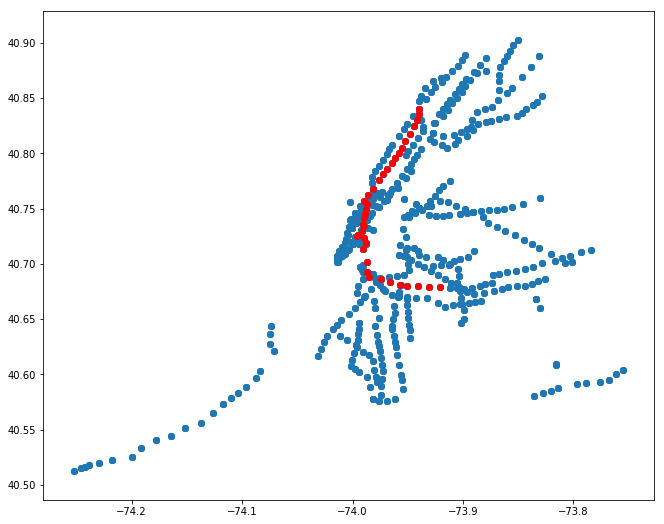

In [445]:
fixed = pd.DataFrame(pairs, columns=["PLSAM", "path"])
fixed["stop_id_O"] = fixed["path"].apply(lambda x: x[0])
fixed["stop_id_D"] = fixed["path"].apply(lambda x: x[-1])

optimal_stops = joined_d.merge(fixed, on=["PLSAM", "stop_id_O", "stop_id_D"])
optimal_stops["num_stations"] = optimal_stops["path"].apply(len)

stops["geometry"] = stops[["stop_lon", "stop_lat"]].apply(sg.Point, axis=1)
stops_g = gpd.GeoDataFrame(stops).set_index("stop_id")
ax = stops_g.plot(figsize=(16, 9))
p = optimal_stops.iloc[55]["path"]
things = []
for stop in p:
    l = stops_g.loc[stop]
    things.append(l)
    gpd.GeoDataFrame(l).swapaxes(0, 1).plot(ax=ax, color='red')

stops_g.head()

### Old code - used for census tract geo information (rather than NYMTC TAZ which is more granular)

In [195]:
stops["line_list"] = stops["line"].apply(lambda x: x.split("-"))
stops.head()

KeyError: 'line'

In [ ]:
# tracts = pd.concat(gpd.read_file(f) for f in glob.glob("gz*.shp
# state_by_tract = {"36": "NY",
#                   "34": "NJ",
#                   "09": "CT"}
# trips_with_destination = trips.merge(tracts, left_on="DTRACT", right_on="clean_geo", how="left",
#                                      suffixes=("_d", "_d"))
# trips_with_od = trips_with_destination.merge(tracts, left_on="OTRACT", right_on="clean_geo", how="left", 
#                                              suffixes=("_o", "_d"))
# tracts["clean_geo"] = tracts.GEO_ID.apply(lambda x: int(x.split("US")[1]))
# trips_with_od["geometry"] = trips_with_od["geometry_o"]
# trips_o_geo = gpd.GeoDataFrame(trips_with_od)
# trips_o_geo[trips_o_geo["TRP_DEP_HR"] < 6].plot()
# len(trips_with_od[trips_with_od["TRP_DEP_HR"] < 5]


# manhattan_counties = {"061"}
# def o_or_d(row):
#     origin =  (row["COUNTY_o"] == "061")
#     destination = (row["COUNTY_d"] == "061")
#     if origin and not destination:
#         return "start"
#     if destination and not origin:
#         return "end"
#     if destination and origin:
#         return "both"
#     return "no"
# trips_o_geo["start_or_end"] = trips_o_geo[["COUNTY_o", "COUNTY_d"]].apply(o_or_d, axis=1)

# of_interest = trips_o_geo[((trips_o_geo["COUNTY_d"] == "061") | 
#                   (trips_o_geo["COUNTY_o"] == "061")) &
#                   (trips_o_geo["TRP_DEP_HR"] < 6)]

# all_subway_trips = trips_o_geo[trips_o_geo["ULTMODE"] == 15]
# interest_subway = of_interest[of_interest["ULTMODE"] == 15]
# len(interest_subway) / float(len(all_subway_trips))

# import matplotlib.pyplot as plt
# fig, axes = plt.subplots(1,  2, figsize=(16, 9))
# interest_subway["geometry"] = interest_subway["geometry_o"]
# interest_subway.plot('start_or_end', categorical=True, legend=True, ax=axes[0])

# interest_subway["geometry"] = interest_subway["geometry_d"]
# interest_subway.plot('start_or_end', categorical=True, legend=True, ax=axes[1])

# (interest_subway["start_or_end"].value_counts() / float(len(interest_subway)))

# import matplotlib
# %matplotlib inline


# areas_2010 = glob.glob("tl*.shp")
# areas_2010

# things = [gpd.read_file(s) for s in areas_2010]
# thing_1 = pd.concat(things)
# gdfs_2010 = gpd.GeoDataFrame(thing_1)

# ax = things[1].plot(figsize=(16, 9), color='red')
# ax = things[0].plot(ax=ax)
# ax = things[2].plot(ax=ax, color='green')

# things[0][things[0]["TAZCE10"].str.contains("2626")]

# trips.head()